# scRNA-seq Analysis of *Parhyale hawaiensis* with Scanpy

Author: Miquel Sendra  
This notebook follows best practices for reproducible single-cell RNA-seq analysis using `scanpy`, starting from STARsolo outputs.

In [41]:
# Imports and settings
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Set up paths
DATA_DIR = Path("../../../workspace/scParhyale_data/raw")
PROC_DATA_DIR = Path("../../../workspace/scParhyale_data/processed")
METADATA_FILE = Path("../../../workspace/scParhyale_data/metadata.xlsx")
LIBRARIES = ["lib01", "lib02", "lib03", "lib04", "lib05", "lib06"]

## Load Metadata

In [31]:
# Load only relevant columns
metadata_df = pd.read_excel(METADATA_FILE, usecols=["Count", "Sample Name"])

# Exctract Stage and Phenotype from 'Sample Name'
metadata_df["Stage"] = metadata_df["Sample Name"].str.extract(r"\((?:Wild-type|Ablated) (\w+)\)")[0]
metadata_df["Phenotype"] = metadata_df["Sample Name"].str.extract(r"\((Wild-type|Ablated)")[0]

# Replace 'Wild-type' with 'WT' for consistency
metadata_df["Phenotype"] = metadata_df["Phenotype"].replace({"Wild-type": "WT"})


# Parse the 'Sample Name' to extract 'Library ID'
metadata_df["Library ID"] = metadata_df["Count"].apply(lambda x: f"lib0{x}")

metadata_df.index = metadata_df["Library ID"]
metadata_df.index = metadata_df.index.astype(str)
metadata_df

,Count,Sample Name,Stage,Phenotype,Library ID
Library ID,,,,,
lib01,1,Library 1 (Wild-type Early),Early,WT,lib01
lib02,2,Library 2 (Ablated Early),Early,Ablated,lib02
lib03,3,Library 3 (Wild-type Mid),Mid,WT,lib03
lib04,4,Library 4 (Ablated Mid),Mid,Ablated,lib04
lib05,5,Library 5 (Wild-type Late),Late,WT,lib05
lib06,6,Library 6 (Ablated Late),Late,Ablated,lib06


## Load STARsolo matrices and build combined AnnData object

In [32]:
# Load libraries and store AnnData objects
adatas = []
for lib in LIBRARIES:
    ad = sc.read_10x_mtx(DATA_DIR / lib, var_names='gene_symbols', cache=True)
    ad.obs["library_id"] = lib
    ad.obs = ad.obs.merge(metadata_df, left_on="library_id", right_index=True)
    ad.var_names_make_unique()
    adatas.append(ad)

# Concatenate all
adata = anndata.concat(
    adatas,
    label="batch",
    keys=LIBRARIES,
    index_unique="-"
)

adata

AnnData object with n_obs × n_vars = 20172 × 54715
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch'

## Preprocessing

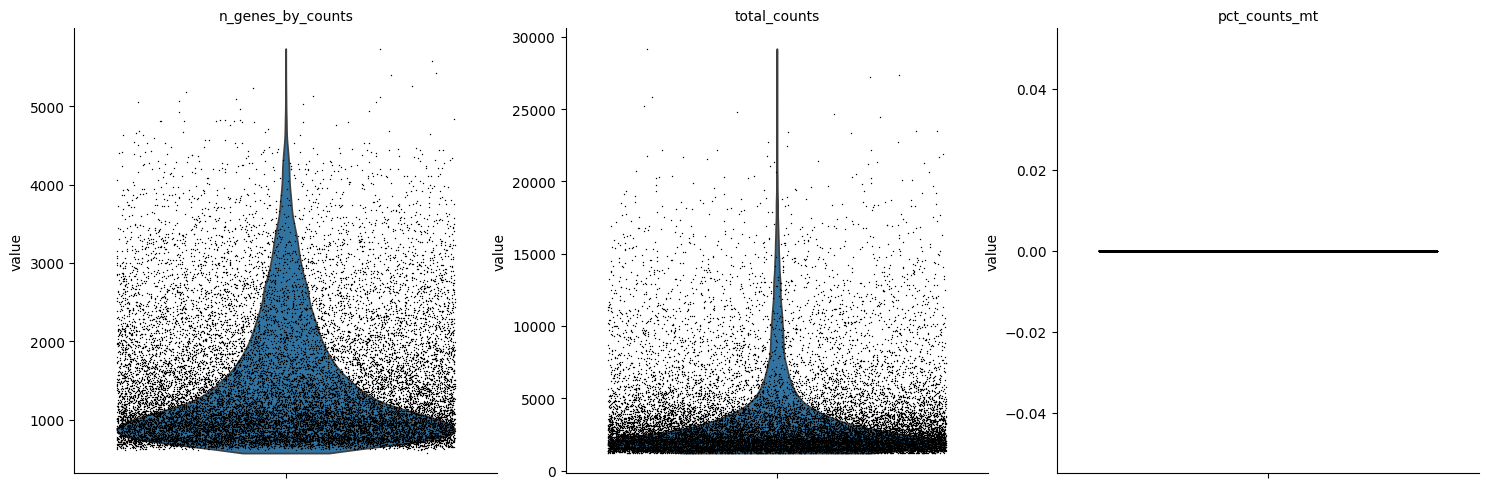

In [33]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# Calculate QC metrics
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
# Plot QC
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

## Filtering based on QC

In [34]:
# Apply thresholds based on inspection
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
# adata = adata[adata.obs.pct_counts_mt < 10, :] # mitocrondrial genes are not annotated in the var gene names
adata

View of AnnData object with n_obs × n_vars = 20172 × 29320
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Normalization and Log Transformation

In [35]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Highly Variable Genes

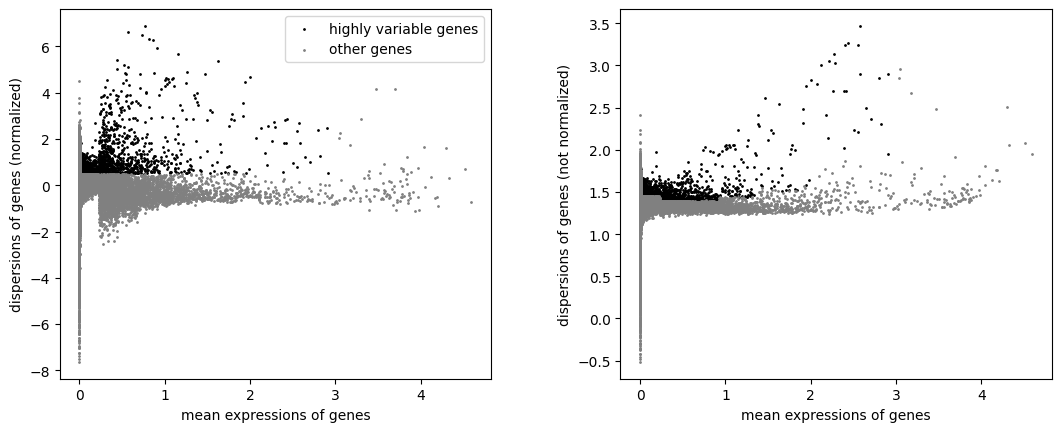

In [36]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

## PCA, Neighbors, UMAP
Initially we start without batch correction (data integration between batches)

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


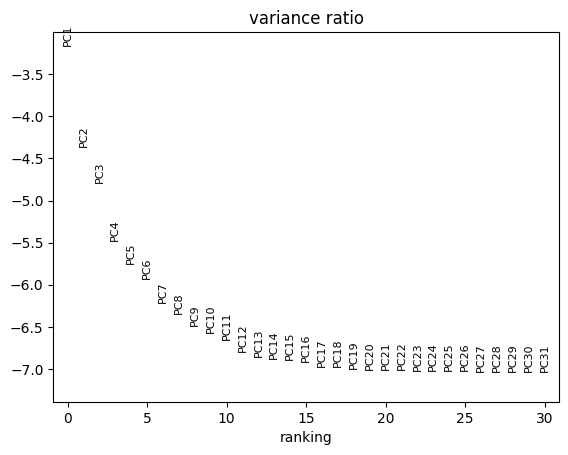

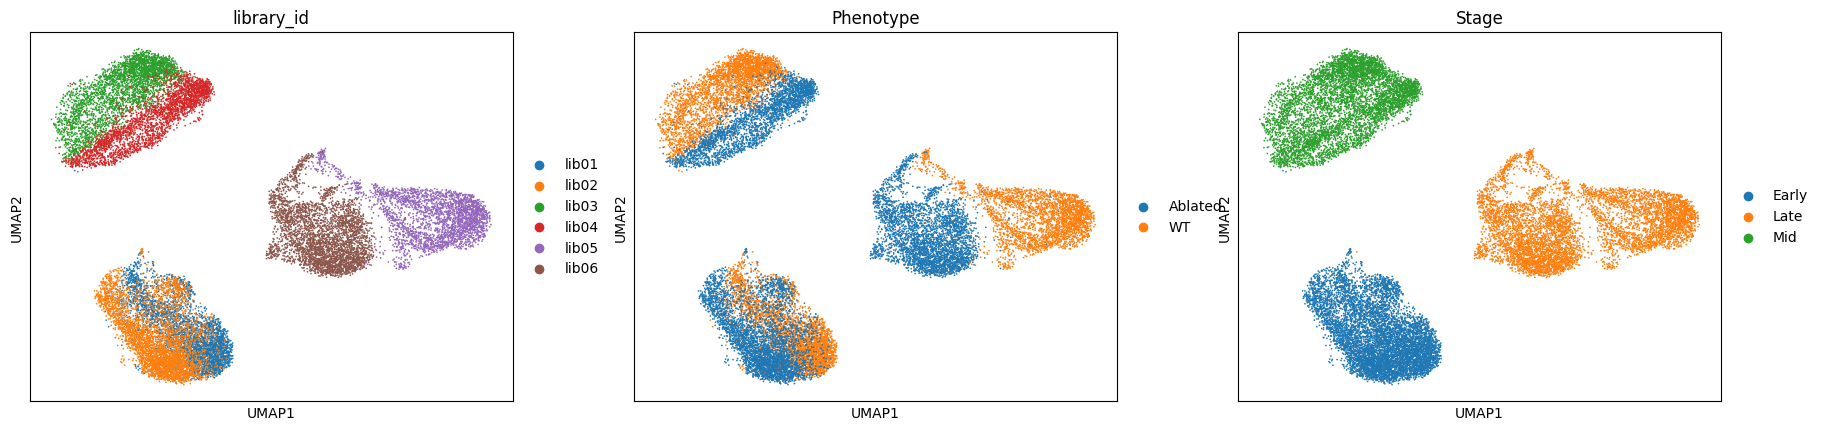

In [37]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['library_id', 'Phenotype', 'Stage'])

## Data integration (batch correction)
Following best practices in scRNAseq
https://www.sc-best-practices.org/cellular_structure/integration.html

Data integration methods work in these steps:
1. Dimensionality reduction.
2. Modeling and removing the batch effect.
3. Projection back into a high-dimensional space.


Batch-effect removal methods can vary in each of these three steps. They may use various linear or non-linear dimensionality reduction approaches, linear or non-linear batch effect models, and they may output different formats of batch-corrected data. Overall, we can divide methods for batch effect removal into 4 categories. In their order of development, these are global models, linear embedding models, graph-based methods, and deep learning approaches.

We will try this three libraries: Harmony, bbknn and scVI.


### Graph-based method: BBKNN (Batch Balanced KNN)
Graph-based method

⚠️ BBKNN modifies the neighborhood graph — do not re-run sc.pp.neighbors() after it.

In [38]:
import scanpy.external as sce

sce.pp.bbknn(adata, batch_key='library_id')
sc.tl.umap(adata)

consider updating your call to make use of `computation`


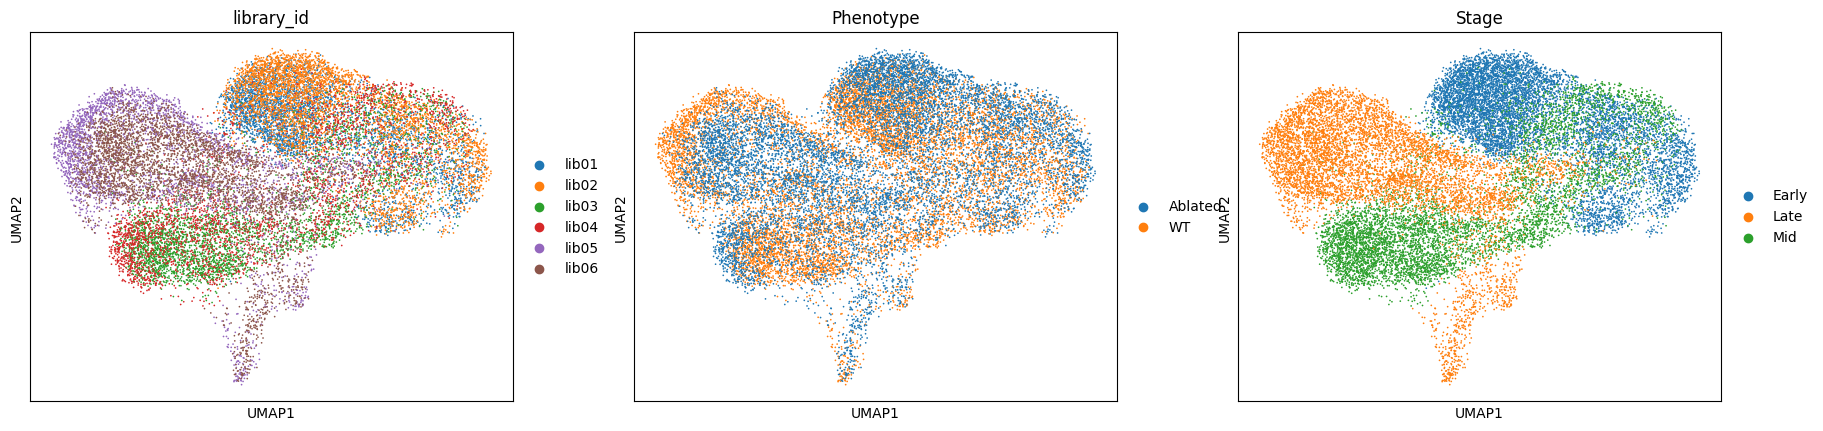

In [39]:
sc.pl.umap(adata, color=["library_id", "Phenotype", "Stage"])

In [42]:
# Save the AnnData object with BBKNN neighbors before applying other batch correction methods
adata_bbknn = adata.copy()
adata_bbknn.write(PROC_DATA_DIR / "adata_bbknn.h5ad")

### Deep learning method: scVI (Single-cell Variational Inference)
Pending, currently I am on the CPU workstation and I don't want to switch

## Clustering

/tmp/ipykernel_311846/4062816493.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


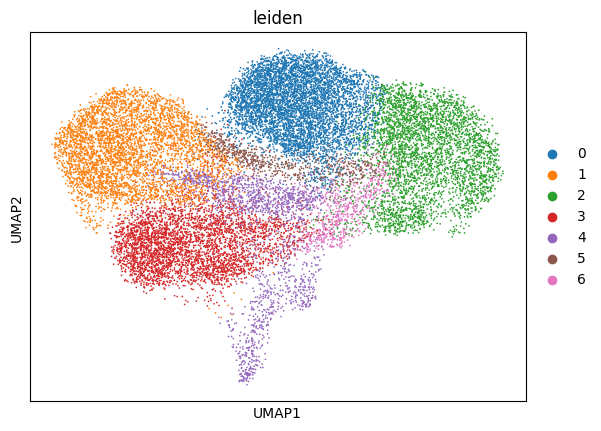

In [47]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])

## Marker Gene Identification

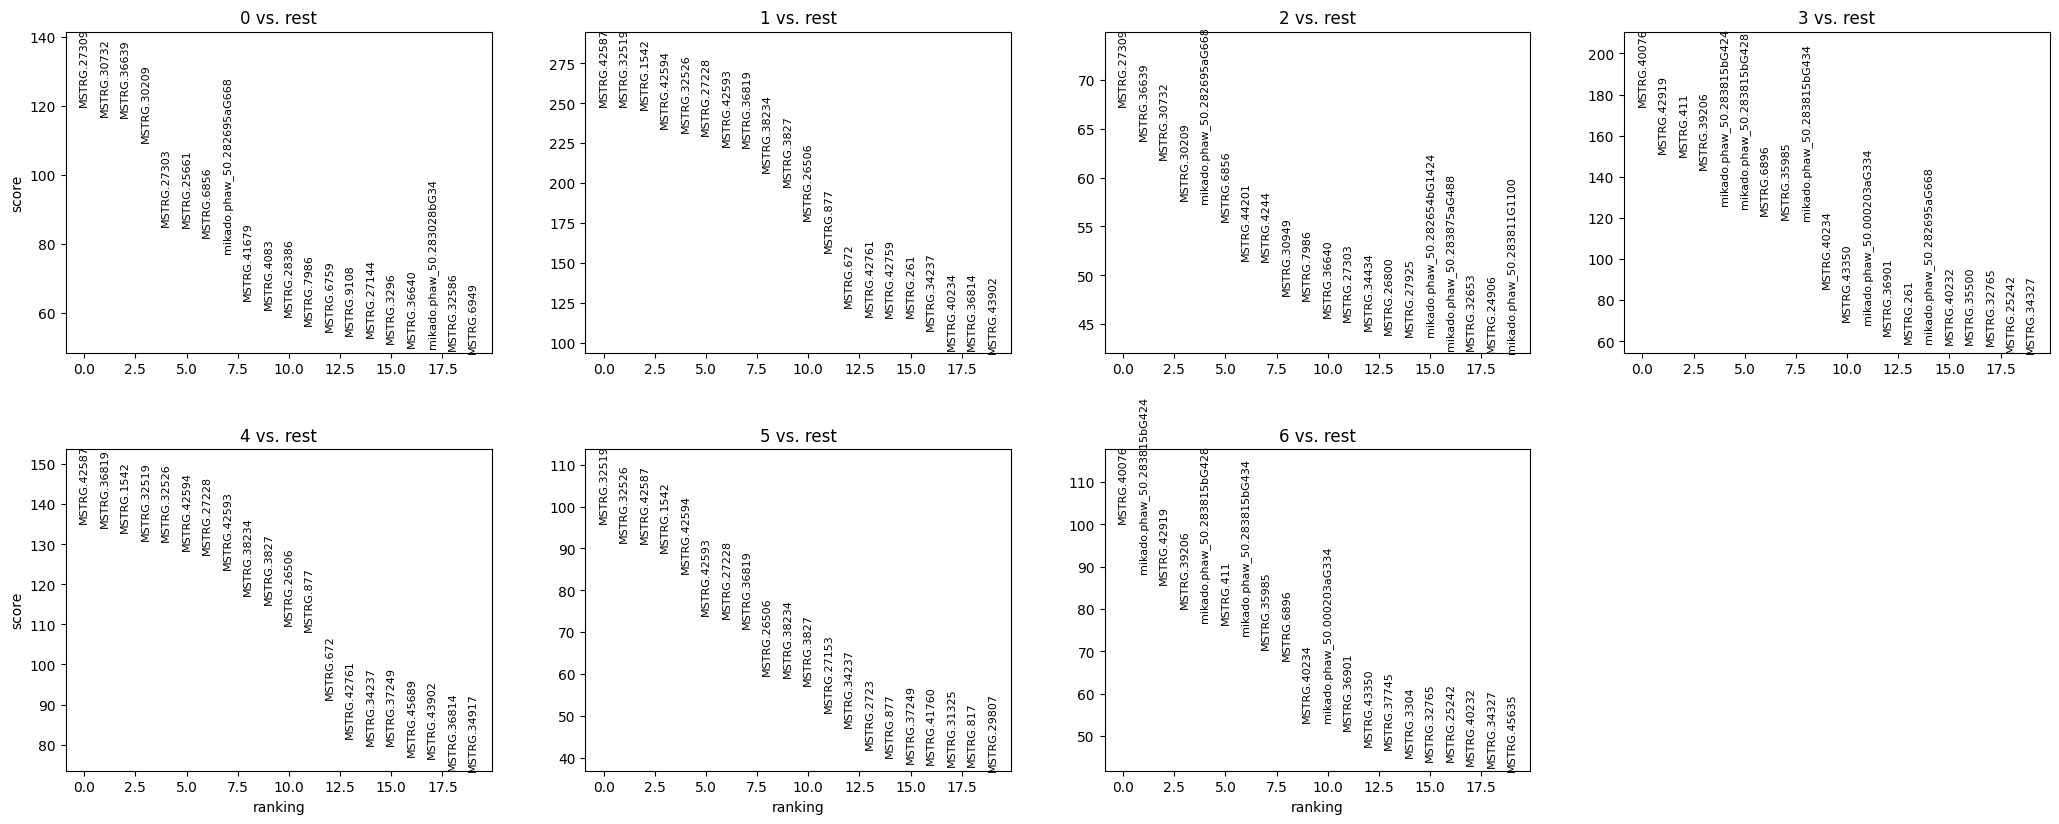

In [48]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## Save Processed Data

In [49]:
adata.write(PROC_DATA_DIR / "adata.h5ad")

In [52]:
adata.var_names

Index(['mikado.phaw_50.000059G4', 'mikado.phaw_50.000059G8', 'MSTRG.21',
       'MSTRG.36', 'MSTRG.42', 'MSTRG.53', 'MSTRG.61', 'MSTRG.82', 'MSTRG.88',
       'MSTRG.98',
       ...
       'MSTRG.45703', 'MSTRG.45706', 'MSTRG.45725', 'MSTRG.45733',
       'mikado.phaw_50.283875aG1352', 'MSTRG.45734', 'MSTRG.45753',
       'MSTRG.45758', 'MSTRG.45761', 'MSTRG.45770'],
      dtype='object', length=2138)

In [56]:
adata.var.head()

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
mikado.phaw_50.000059G4,111,False,111,0.005552,99.449732,112.0,True,0.017041,1.501157,0.705968,0.007079,0.102660
mikado.phaw_50.000059G8,194,False,194,0.009816,99.038271,198.0,True,0.029798,1.524944,0.804338,0.012352,0.135688
MSTRG.21,2319,False,2319,0.126661,88.503867,2555.0,True,0.300804,1.406335,0.651052,0.147237,0.440426
MSTRG.36,4510,False,4510,0.492961,77.642276,9944.0,True,0.860180,1.979574,6.299910,0.410134,0.798800
MSTRG.42,3302,False,3302,0.189768,83.630775,3828.0,True,0.447082,1.467531,1.634299,0.224501,0.545165


In [ ]:
adata.obs

,library_id,Count,Sample Name,Stage,Phenotype,Library ID,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAAACCGCCATGAAAC-lib01,lib01,1,Library 1 (Wild-type Early),Early,WT,lib01,lib01,1032,1032,2424.0,0.0,0.0,0
AAAACCGCCATGAAAG-lib01,lib01,1,Library 1 (Wild-type Early),Early,WT,lib01,lib01,1223,1222,2996.0,0.0,0.0,2
AAAACCGCCATGAACT-lib01,lib01,1,Library 1 (Wild-type Early),Early,WT,lib01,lib01,756,756,1464.0,0.0,0.0,0
AAAACCGCCATGAAGG-lib01,lib01,1,Library 1 (Wild-type Early),Early,WT,lib01,lib01,750,749,1439.0,0.0,0.0,0
AAAACCGCCATGAATA-lib01,lib01,1,Library 1 (Wild-type Early),Early,WT,lib01,lib01,904,904,1980.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCTCTAATGTGCTT-lib06,lib06,6,Library 6 (Ablated Late),Late,Ablated,lib06,lib06,932,932,2011.0,0.0,0.0,1
TTGCTCTAATGTGTAT-lib06,lib06,6,Library 6 (Ablated Late),Late,Ablated,lib06,lib06,1747,1747,3060.0,0.0,0.0,1
TTGCTCTAATGTTAAC-lib06,lib06,6,Library 6 (Ablated Late),Late,Ablated,lib06,lib06,976,975,1928.0,0.0,0.0,1
TTGCTCTAATGTTGGT-lib06,lib06,6,Library 6 (Ablated Late),Late,Ablated,lib06,lib06,1370,1370,2214.0,0.0,0.0,5
